In [ ]:
import pandas as pd
import numpy as np
from pandas import DataFrame
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from tensorflow.keras.layers import Dense
from tensorflow.keras import layers
from tensorflow.keras.layers import LSTM
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, LSTM
from keras.layers.core import Dropout
#from tensorflow.keras.optimizers import Adam
from keras import optimizers
import keras.backend as K
from tensorflow.keras.metrics import categorical_crossentropy, mean_squared_error
import math
from math import sqrt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller
import matplotlib.patches as mpatches

In [ ]:
# data import
data = pd.read_csv('resid_decomposed.csv')
data

,Unnamed: 0,resid
0,2015-07-01,NaN
1,2015-07-02,NaN
2,2015-07-03,NaN
3,2015-07-04,-7.777854
4,2015-07-05,-16.413058
...,...,...
783,2017-08-22,10.657095
784,2017-08-23,29.028268
785,2017-08-24,NaN
786,2017-08-25,NaN


preprocess

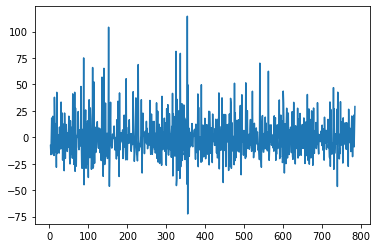

In [ ]:
data = data[pd.notnull(data['resid'])]
df = data['resid']
plt.plot(df)

ADF stationary test

In [ ]:
series = df
adf = adfuller(series)

print('ADF Statistic: %f' % adf[0])
print('p-value: %f' % adf[1])
print('Critical Values:')
for key, value in adf[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -11.845704
p-value: 0.000000
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569


In [ ]:
data = pd.DataFrame(series)
data = np.array(data)
data.shape

(782, 1)

Data split (8:2)

In [ ]:
size = int(len(data)*0.8)
train = data[0:size,:]
test = data[size:len(data),:]
print(train.shape)
print(test.shape)

(625, 1)
(157, 1)


Data normalization (0 to 1)

Text(0.5, 1.0, 'Normalized training data')

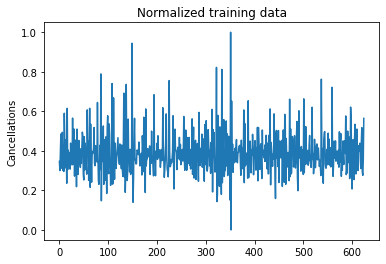

In [ ]:
scale = MinMaxScaler(feature_range=(0,1))
train = scale.fit_transform(train)
test = scale.fit_transform(test)

plt.plot(train)
plt.ylabel('Cancellations')
plt.title('Normalized training data')

creating inout sequence

In [ ]:
def inout(df, previous=1):
    dataX, dataY = [], []
    for i in range(len(df)-previous-1):
        a = df[i:(i+previous), 0]
        dataX.append(a)
        dataY.append(df[i + previous, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
# training window
tw = 30

In [ ]:
train_x, train_y = inout(train,tw)
train_x = np.reshape(train_x,(train_x.shape[0],1,train_x.shape[1]))
test_x, test_y = inout(test,tw)
test_x = np.reshape(test_x,(test_x.shape[0],1,test_x.shape[1]))

print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(594, 1, 30)
(594,)
(126, 1, 30)
(126,)


Modeling

In [ ]:
# model setting
def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred -y_true), axis=-1))

model = Sequential()
model.add(layers.GRU(50, return_sequences=True,
               input_shape=(1,tw)))
model.add(Dropout(0.2))
model.add(layers.GRU(10, return_sequences=False))
model.add(Dropout(0.1))
model.add(Dense(1, activation = 'linear'))

# optimizer, loss function
model.compile(optimizer = 'adam', loss='mean_squared_error')

# summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 1, 50)             12300     
_________________________________________________________________
dropout (Dropout)            (None, 1, 50)             0         
_________________________________________________________________
gru_1 (GRU)                  (None, 10)                1860      
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 11        
Total params: 14,171
Trainable params: 14,171
Non-trainable params: 0
_________________________________________________________________


In [ ]:
fitting = model.fit(train_x, train_y,
                    #validation_split=0.2,
                    validation_data = (test_x, test_y),
                    epochs=100,
                    batch_size=10, 
                    verbose=2) # show training sequence

Epoch 1/100
60/60 - 12s - loss: 0.0331 - val_loss: 0.0328
Epoch 2/100
60/60 - 0s - loss: 0.0170 - val_loss: 0.0320
Epoch 3/100
60/60 - 0s - loss: 0.0156 - val_loss: 0.0294
Epoch 4/100
60/60 - 0s - loss: 0.0146 - val_loss: 0.0327
Epoch 5/100
60/60 - 0s - loss: 0.0162 - val_loss: 0.0295
Epoch 6/100
60/60 - 0s - loss: 0.0146 - val_loss: 0.0300
Epoch 7/100
60/60 - 0s - loss: 0.0147 - val_loss: 0.0312
Epoch 8/100
60/60 - 0s - loss: 0.0134 - val_loss: 0.0327
Epoch 9/100
60/60 - 0s - loss: 0.0131 - val_loss: 0.0356
Epoch 10/100
60/60 - 0s - loss: 0.0130 - val_loss: 0.0303
Epoch 11/100
60/60 - 0s - loss: 0.0129 - val_loss: 0.0365
Epoch 12/100
60/60 - 0s - loss: 0.0125 - val_loss: 0.0382
Epoch 13/100
60/60 - 0s - loss: 0.0127 - val_loss: 0.0309
Epoch 14/100
60/60 - 0s - loss: 0.0133 - val_loss: 0.0276
Epoch 15/100
60/60 - 0s - loss: 0.0116 - val_loss: 0.0300
Epoch 16/100
60/60 - 0s - loss: 0.0119 - val_loss: 0.0309
Epoch 17/100
60/60 - 0s - loss: 0.0122 - val_loss: 0.0283
Epoch 18/100
60/60 - 0

Evaluation

In [ ]:
# plot loss history function
def loss_plot(loss, val_loss):
  #plt.figure(figsize=(13,7))
  plt.plot(loss)
  plt.plot(val_loss)
  plt.title('Loss evaluation')
  plt.legend(['Train','Validation'])
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
#  plt.show()

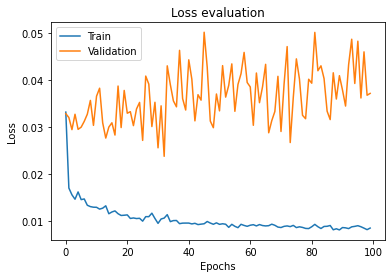

In [ ]:
# loss history
loss_plot(fitting.history['loss'],
        fitting.history['val_loss'])
plt.savefig("GRU residual loss eval.png")

In [ ]:
# RMSE score
def predict_and_score(model, X, Y):
    pred = scale.inverse_transform(model.predict(X))
    orig_data = scale.inverse_transform([Y])
    score = math.sqrt(mean_squared_error(orig_data[0], pred[:, 0]))
    return(score, pred)

rmse_train, train_predict = predict_and_score(model, train_x, train_y)
rmse_test, test_predict = predict_and_score(model, test_x, test_y)

print("Training data score: %.2f RMSE" % rmse_train)
print("Test data score: %.2f RMSE" % rmse_test)

Training data score: 8.19 RMSE
Test data score: 18.01 RMSE


Prediction

In [ ]:
# forecast on training set
train_fcst = model.predict(train_x)
# forecast on test set
test_fcst = model.predict(test_x)


print(train_fcst.shape)
print(test_fcst.shape)

(594, 1)
(126, 1)


In [ ]:
# mean directional accuracy
def mda(actual: np.ndarray, predicted: np.ndarray):
    return np.mean((np.sign(actual[1:] - actual[:-1]) ==\
                    np.sign(predicted[1:] - predicted[:-1])).astype(int))*100

print('Training MDA:', mda(train_y, train_fcst),'%')
print('Testing MDA: ',mda(test_y, test_fcst),'%')

Training MDA: 49.89122676305065 %
Testing MDA:  49.971199999999996 %


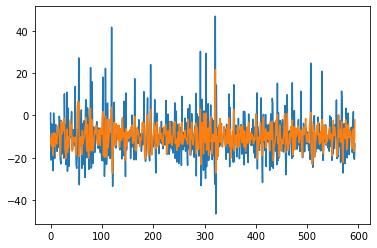

In [ ]:
# forecast on training
plt.plot(scale.inverse_transform(train_y.reshape(-1,1)))
plt.plot(scale.inverse_transform(train_fcst))

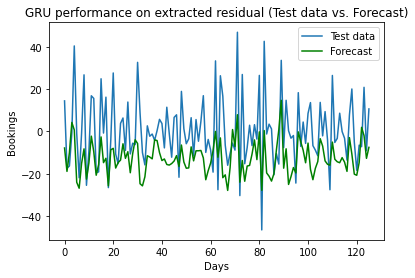

In [ ]:
# forecast on testing data
plt.plot(scale.inverse_transform(test_y.reshape(-1,1)))
plt.plot(scale.inverse_transform(test_fcst), 'g')
plt.legend(['Test data','Forecast'])
plt.title("GRU performance on extracted residual (Test data vs. Forecast)")
plt.ylabel('Bookings')
plt.xlabel('Days')

#left, bottom, width, height = (100, 60, 20, 30)
#rect=mpatches.Rectangle((left,bottom),width,height, 
#                        fill=False,
#                        color="red",
#                       linewidth=1)

#plt.gca().add_patch(rect)

#plt.show()

plt.savefig("GRU residual.png")